# Lab 5: Сегментація зображень. Стиснення/кодування зображення.
### Шевченко Юлія, ФІ-31мн

## Implementation of Floyd-Steinberg Dithering Algorithm

In this task, we are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case a digital image) to improve its perceptual quality. By introducing noise, the objective quality may degrade, but the subjective quality, or how the image appears to the human eye, can improve.

For detailed information about the Floyd-Steinberg dithering algorithm, refer to this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. To implement the dithering process, we will follow these steps:

1. **Define Color Palette**:
   - Before applying dithering, we need to define a color palette. This palette represents the set of colors available for rendering the image. Typically, this palette consists of a limited number of colors to reduce computational complexity and memory usage.

2. **Quantize the Image**:
   - The first step in the dithering process is to quantize the image. Quantization involves mapping the colors in the original image to the closest colors available in the defined color palette. This step establishes a baseline for subsequent dithering operations and computes the average quantization error.

3. **Implement Floyd-Steinberg Dithering**:
   - The core of the dithering process involves the Floyd-Steinberg algorithm. This algorithm distributes quantization errors from higher to lower spatial frequencies in the image, resulting in an improved perceptual quality. By diffusing the error to neighboring pixels, Floyd-Steinberg dithering minimizes visual artifacts such as banding and posterization. After applying the algorithm, we compute the average quantization error to evaluate the effectiveness of the dithering process.

Floyd-Steinberg dithering offers a versatile approach to enhance the visual quality of digital images, particularly in scenarios where the available color depth is limited. By implementing these steps effectively, we can achieve improved subjective quality in the rendered images, despite the introduction of noise during the dithering process.


In [1]:
# All the imports for the task
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

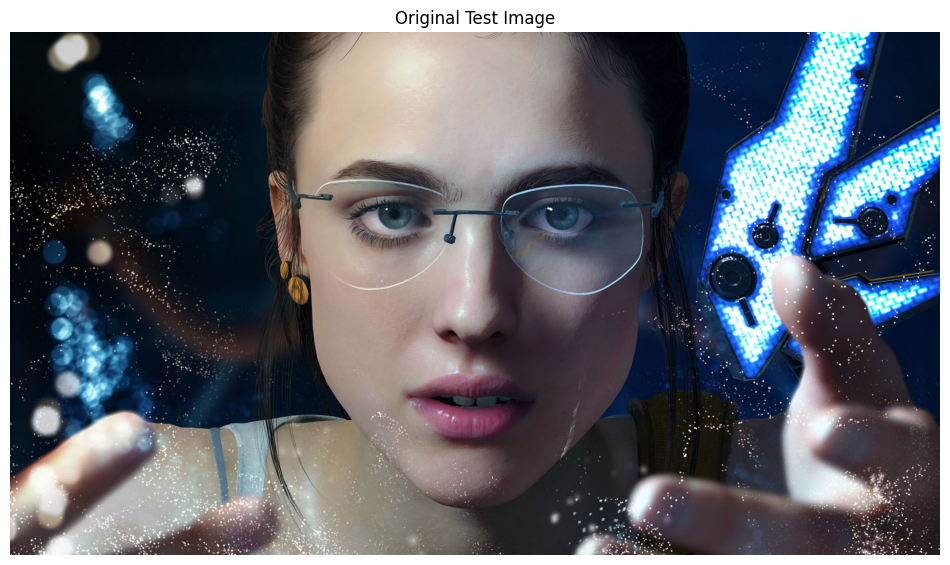

In [2]:
# Loading the test image
image_path = '../Lab_5/test_img.jpg'
image = cv2.imread(image_path)

# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title('Original Test Image')
plt.axis('off')
plt.show()

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the color palette, let's quantize the original image.

In [4]:
def quantize_image(img: np.ndarray, palette: np.ndarray) -> np.ndarray:
    """
    Quantizes the input image using the provided palette.

    Args:
        img (np.ndarray): Input image.
        palette (np.ndarray): Palette containing colors for quantization.

    Returns:
        np.ndarray: Quantized image.
    """
    # Cast the image to float
    img = img.astype(float)

    # Prepare for quantization
    rows, cols, channels = img.shape
    quantized = np.zeros_like(img)

    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img[r, c, :]

            # Find the closest color from the palette (using absolute value/Euclidean distance)
            distances = np.sum((palette - pixel) ** 2, axis=1)
            closest_color_index = np.argmin(distances)
            new_pixel = palette[closest_color_index]

            # Apply quantization
            quantized[r, c, :] = new_pixel

    return quantized

In [5]:
quantized_image = quantize_image(image, colors)

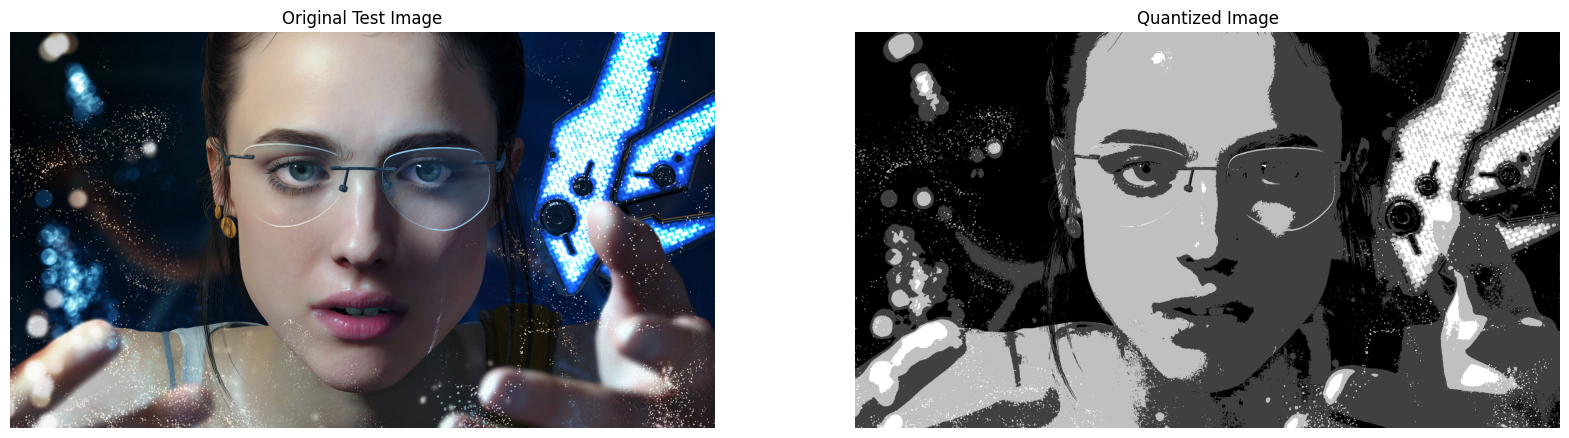

In [6]:
# Show quantized image (remember to cast back to uint8)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(image.astype(np.uint8))
axes[0].set_title('Original Test Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(quantized_image.astype(np.uint8))
axes[1].set_title('Quantized Image')
axes[1].axis('off')

plt.show()

In [7]:
avg_quant_error = np.mean(np.abs(image - quantized_image))

print('Average quantization error: {}'.format(avg_quant_error))

Average quantization error: 24.535866769547326


## Implementation of Floyd-Steinberg Dithering

In this section, we will delve into the implementation of the Floyd-Steinberg (FS) dithering algorithm and compare its results to the optimally quantized image computed previously.

In [8]:
def dither_image(img: np.ndarray, palette: np.ndarray) -> np.ndarray:
    """
    Applies dithering to the input image using the provided palette.

    Args:
        img (np.ndarray): Input image.
        palette (np.ndarray): Palette containing colors for dithering.

    Returns:
        np.ndarray: Dithered image.
    """
    # Make a temporal copy of the original image, we will need it for error diffusion
    img_tmp = img.astype(float)  # Cast to float
    dithering = np.zeros_like(img)

    # Define the Floyd-Steinberg diffusion matrix
    fs_matrix = np.array([[0, 0, 7/16],
                          [3/16, 5/16, 1/16]])

    rows, cols, _ = img.shape

    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]

            # Find the closest color from the palette (using absolute value/Euclidean distance)
            distances = np.sum((palette - pixel) ** 2, axis=1)
            closest_color_index = np.argmin(distances)
            new_pixel = palette[closest_color_index]

            # Compute quantization error
            quant_error = pixel - new_pixel

            # Diffuse the quantization error according to the FS diffusion matrix
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if abs(dr) == 1 and abs(dc) == 1:
                        diffusion_factor = fs_matrix[1, 1]
                    else:
                        diffusion_factor = fs_matrix[abs(dr), abs(dc)]

                    img_tmp[r + dr, c + dc, :] += quant_error * diffusion_factor

            # Apply dithering
            dithering[r, c, :] = new_pixel

    return dithering

In [9]:
dithered_image = dither_image(image, colors)

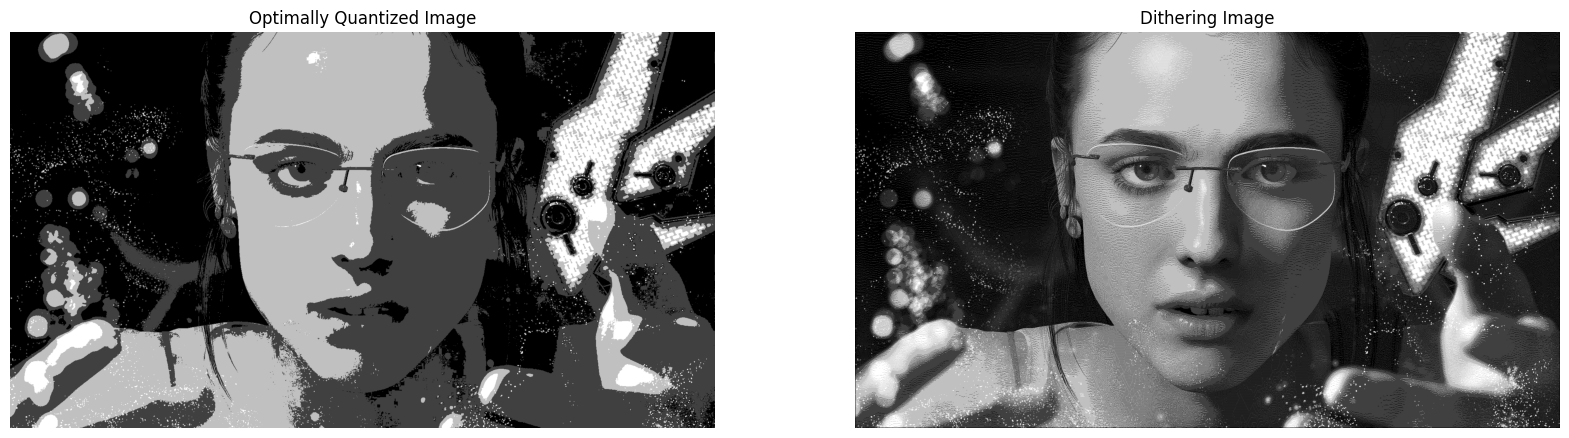

In [10]:
# Show quantized image (remember to cast back to uint8)
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()

In [11]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.abs(image - dithered_image))

print('Average quantization error for dithered image: {}'.format(avg_dith_error))

Average quantization error for dithered image: 121.48885497042181


## Questions

**Which image has higher quantization error? Optimally quantized or dithered?**

To determine which image has a higher quantization error, we need to compare `avg_quant_error` and `avg_dith_error` to identify which is higher. The image with the higher average quantization error will have more noticeable discrepancies between the original and quantized/dithered versions. We can run the code below:

In [12]:
print('{} Image has higher quantization error'.format('Optimally Quantized' if avg_quant_error > avg_dith_error else 'Dithered'))

Dithered Image has higher quantization error


**Which image looks better to you?**

In comparing the two images, I find the dithered image to be particularly captivating due to its enhanced detail and realism. The method of dithering has effectively introduced subtle variations in tone, resulting in a visually engaging image with intricate textures and nuances.

However, it's important to note that the optimally quantized image also possesses its own allure. While it may not exhibit the same level of detail as the dithered counterpart, its clean and smooth transitions between colors lend it a certain elegance and simplicity. In the context of artistic endeavors, such as poster design, the optimally quantized image could serve as a striking visual element, offering a refined and polished aesthetic.

Furthermore, considering the potential for expanding the color palette used in quantization, the optimally quantized approach presents an opportunity for exploration. By incorporating a broader range of colors, it could potentially bridge the gap between the richness of the dithered image and the precision of the optimally quantized one, offering a versatile solution suitable for a variety of creative applications.

Ultimately, the choice between the dithered and optimally quantized images depends on the specific context and desired aesthetic outcome. Both approaches offer distinct visual experiences, each with its own merits and potential for artistic expression.

Let`s try to make quantization using expanded palette:

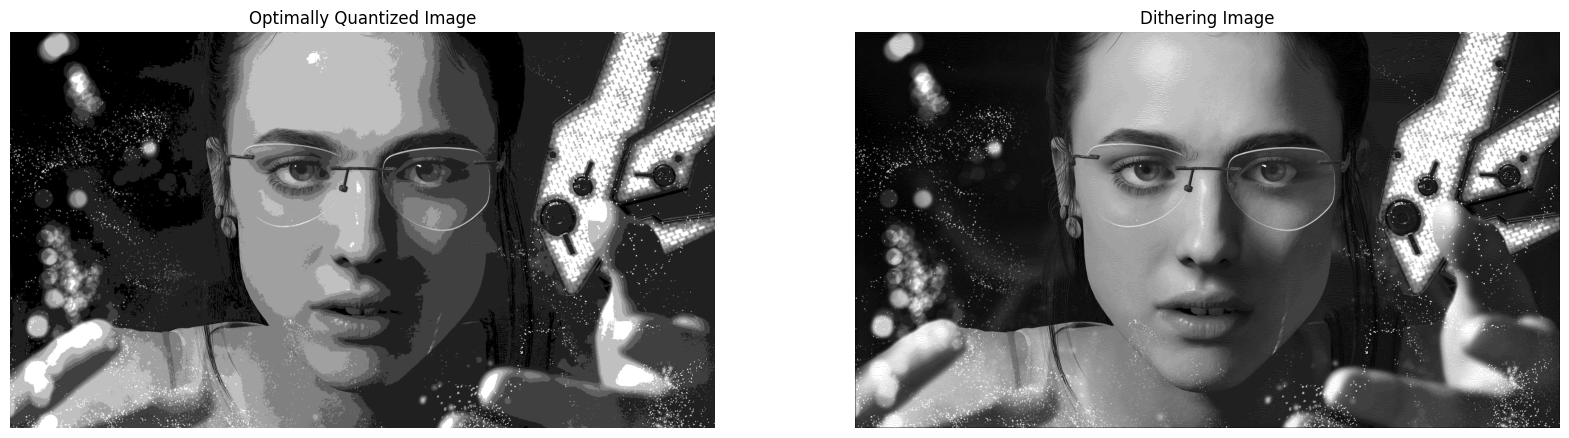

In [13]:
static_gray_palette = np.array([[0, 0, 0],          # Black
                                [32, 32, 32],       # Dark gray
                                [64, 64, 64],       # Medium dark gray
                                [96, 96, 96],       # Medium gray
                                [128, 128, 128],    # Gray
                                [160, 160, 160],    # Medium light gray
                                [192, 192, 192],    # Light gray
                                [255, 255, 255]])   # White

quantized_image_expanded = quantize_image(image, static_gray_palette)
dithered_image_expanded = dither_image(image, static_gray_palette)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image_expanded.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image_expanded.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()

**Can you repeat the same process using only two colours: black and white? Show me :-)**

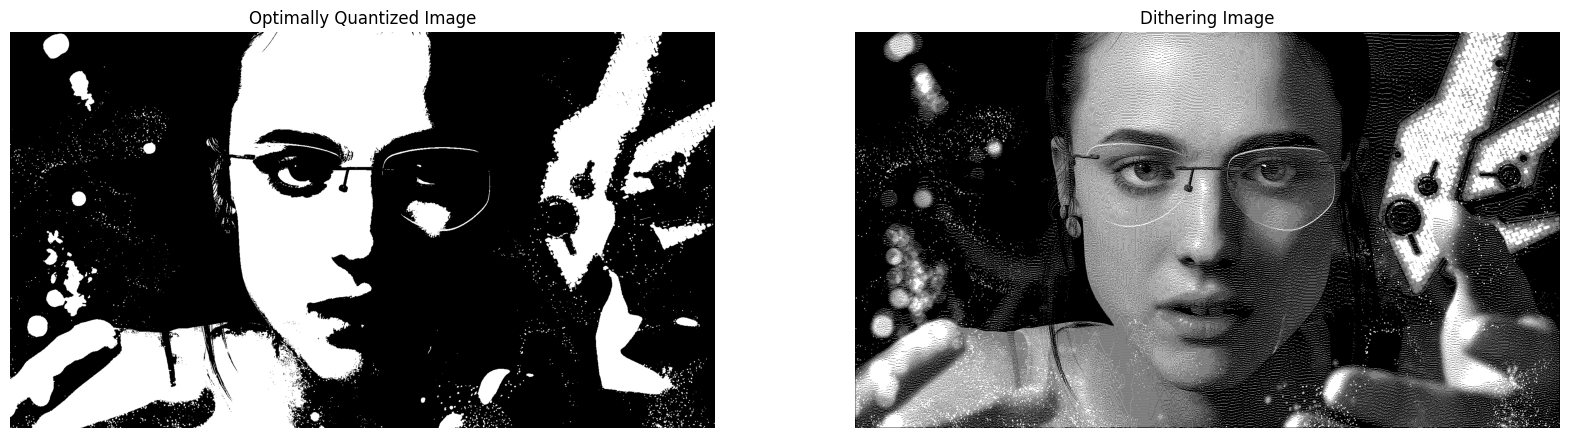

In [14]:
black_and_white_palette = np.array([[0, 0, 0], [255, 255, 255]])

quantized_image_bw = quantize_image(image, black_and_white_palette)
dithered_image_bw = dither_image(image, black_and_white_palette)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image_bw.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image_bw.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()

## Extra tests

Let`s repeat the task using a different image palette. For instance, you can use an optimal color palette that we can calculate via k-means algorithm. The following snippet of code will give you the 16 optimal colors for your original image.

**How does the result look like to you?**

The dithered image using the optimal color palette from the k-means algorithm appears visually pleasing with smooth transitions between colors. The algorithm effectively selects 16 representative colors from the original image, resulting in a coherent and accurate representation. The dithering process helps mitigate color banding and produces a natural-looking image with good overall fidelity to the original.

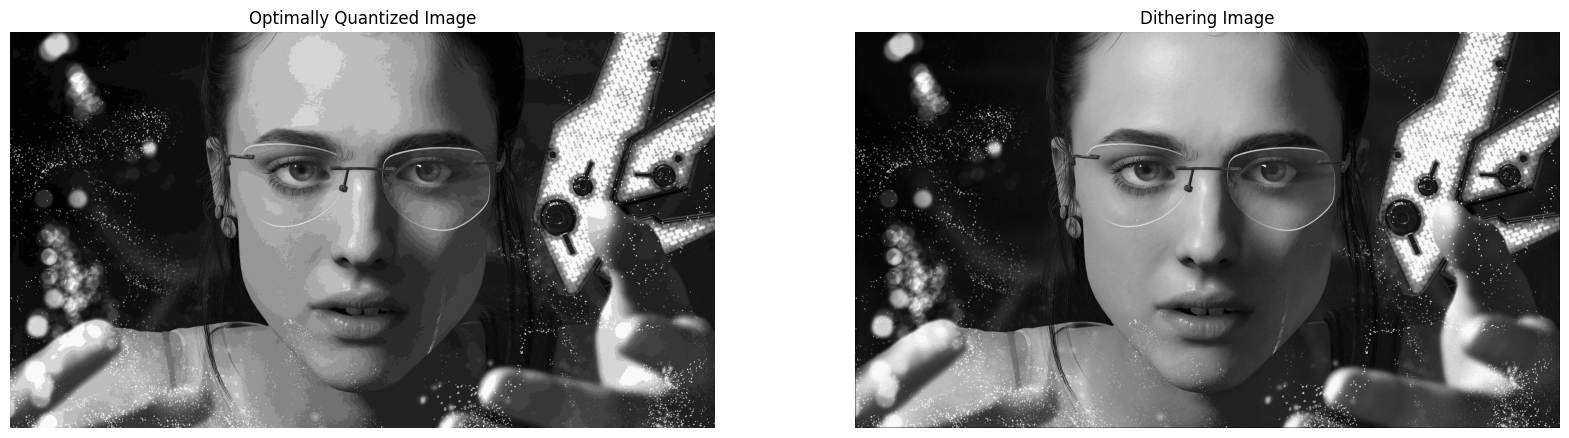

In [15]:
kmeans = KMeans(n_clusters=16).fit(np.reshape(image, (-1, 1)))
optimal_palette_16 = kmeans.cluster_centers_

quantized_image_16 = quantize_image(image, optimal_palette_16)
dithered_image_16 = dither_image(image, optimal_palette_16)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image_16.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image_16.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()

**What happens if we use 32 colors?**

Increasing the number of colors in the palette to 32 yields a dithered image with enhanced color depth and detail compared to the 16-color version. The additional colors allow for finer gradients and more precise color representation, resulting in a visually richer image. However, the difference between the 16-color and 32-color versions might not be as pronounced, especially for images with limited color variation.

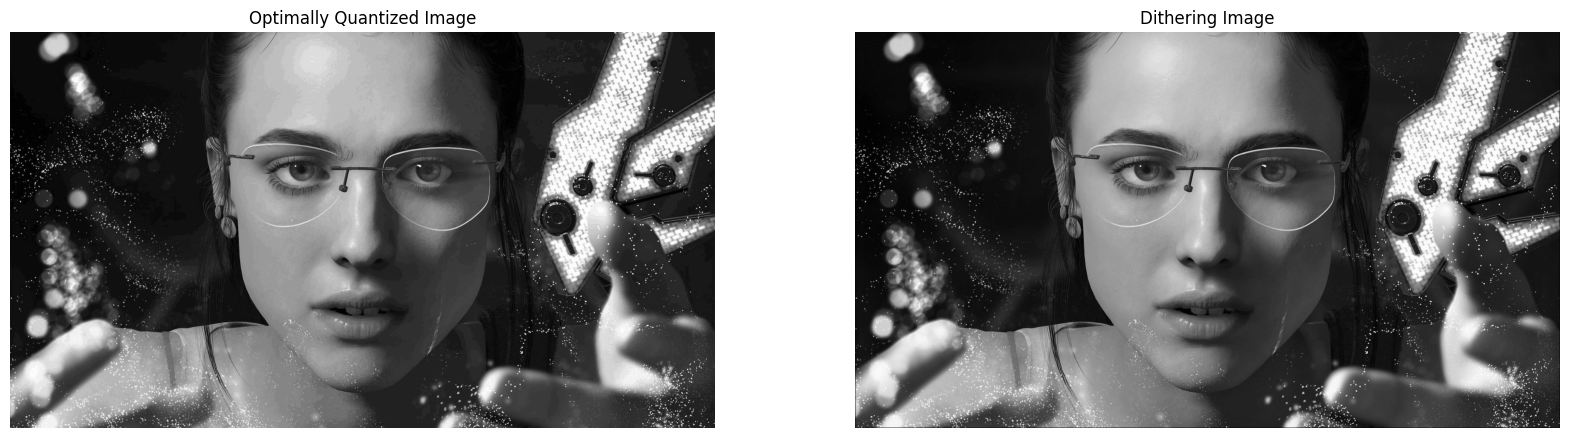

In [16]:
kmeans = KMeans(n_clusters=32).fit(np.reshape(image, (-1, 1)))
optimal_palette_32 = kmeans.cluster_centers_

quantized_image_32 = quantize_image(image, optimal_palette_32)
dithered_image_32 = dither_image(image, optimal_palette_32)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image_32.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image_32.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()

**And what happens if we use 256 colors?**

Using a palette of 256 colors further improves the color accuracy and fidelity of the dithered image. With a larger number of colors, the dithering algorithm can better approximate the original image's color distribution, resulting in smoother gradients and more nuanced shading. However, the computational complexity increases significantly, leading to longer processing times and potentially larger file sizes. Additionally, the visual difference between the 32-color and 256-color versions might be less noticeable, especially for images with fewer distinct colors.

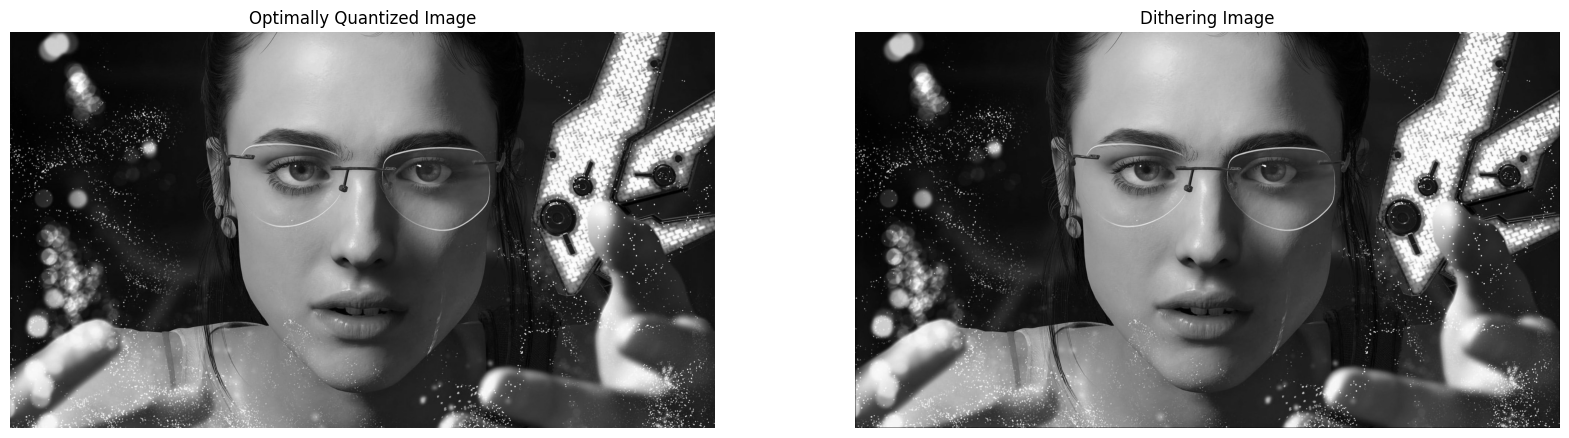

In [17]:
kmeans = KMeans(n_clusters=256).fit(np.reshape(image, (-1, 1)))
optimal_palette_256 = kmeans.cluster_centers_

quantized_image_256 = quantize_image(image, optimal_palette_256)
dithered_image_256 = dither_image(image, optimal_palette_256)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Plot the original image
axes[0].imshow(quantized_image_256.astype(np.uint8))
axes[0].set_title('Optimally Quantized Image')
axes[0].axis('off')

# Plot the quantized image
axes[1].imshow(dithered_image_256.astype(np.uint8))
axes[1].set_title('Dithering Image')
axes[1].axis('off')

plt.show()